In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

# Measures of Predictive Accuracy


## Training and test datasets

You cannot test how good your model is using the training dataset.
Whatever the metric you use, your model's performance on the training dataset will always be quite good.
The model is tuned to do well on the training data.
The real question is how well your model does on a dataset it has never seen.
This brings us to the concept of a *test dataset*.
How can you make a test dataset?
Well, take whatever data you have and split them into training and test datasets.
For example, you can randomly select 70% of your data and put it in your training set and 30% of the data and put it in your test set.

Let's do this for the motorcycle dataset:

In [2]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/motor.dat"
download(url)
data = np.loadtxt('motor.dat')

x = data[:, 0]
y = data[:, 1]

We are going to use the functionality of the Python library [scikitlearn](https://scikit-learn.org/stable/) to split our dataset into training and testing.

In [4]:
np.random.seed(12345)

from sklearn.model_selection import train_test_split

# Here is how you use it
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

Let's plot the training and the test datasets in different colors:

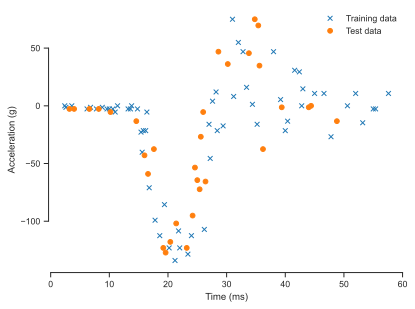

In [5]:
fig, ax = plt.subplots()
ax.plot(x_train, y_train, 'x', label='Training data')
ax.plot(x_test, y_test, 'o', label='Test data')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Acceleration (g)')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

## Fit the model on the training set

Let's repeat here the code that calculates the design matrix for polynomial, Fourier, and radial basis functions:

In [6]:
def get_polynomial_design_matrix(x, degree):
    """Return the polynomial design matrix of ``degree`` evaluated at ``x``.
    
    Arguments:
    x      -- A 2D array with only one column.
    degree -- An integer greater than zero.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    cols = []
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

def get_fourier_design_matrix(x, L, num_terms):
    """Fourier expansion with ``num_terms`` cosines and sines.
    
    Arguments:
    x          --  A 2D array with only one column.
    L          --  The "length" of the domain.
    num_terms  --  How many Fourier terms do you want.
                   This is not the number of basis
                   functions you get. The number of basis functions
                   is 1 + num_terms / 2. The first one is a constant.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    for i in range(int(num_terms / 2)):
        cols.append(np.cos(2 * (i+1) * np.pi / L * x))
        cols.append(np.sin(2 * (i+1) * np.pi / L * x))
    return np.hstack(cols)
                    
def get_rbf_design_matrix(x, x_centers, ell):
    """Radial basis functions design matrix.
    
    Arguments:
    x        --  The input points on which you want to evaluate the
                 design matrix.
    x_center --  The centers of the radial basis functions.
    ell      --  The lengthscale of the radial basis function.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    for i in range(x_centers.shape[0]):
        cols.append(np.exp(-(x - x_centers[i]) ** 2 / ell))
    return np.hstack(cols)

Let's fit a polynomial model like before:

In [7]:
degree = 3
Phi_poly_train = get_polynomial_design_matrix(
    x_train[:, None],
    degree
)
w_poly, _, _, _ = np.linalg.lstsq(
    Phi_poly_train,
    y_train,
    rcond=None
)

Let's compare to the data:

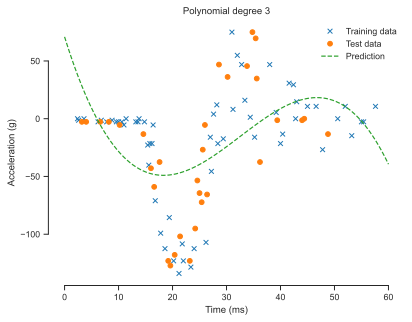

In [8]:
xx = np.linspace(0, 60, 100)
Phi_poly_xx = get_polynomial_design_matrix(xx[:, None], degree)
yy_predict = Phi_poly_xx @ w_poly

fig, ax = plt.subplots()
ax.set_title(f'Polynomial degree {degree}')
ax.plot(x_train, y_train, 'x', label='Training data')
ax.plot(x_test, y_test, 'o', label='Test data')
ax.plot(xx, yy_predict, '--', label='Prediction')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Acceleration (g)')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

## Test the model with the test set: The predictions-vs-observations plot

As you can imagine, you can only do this if the input has less than two dimensions.
In higher dimensions, we typically do the predictions-vs-observations plot for the test data.
We also call it the parity plot.
Here is how it looks:

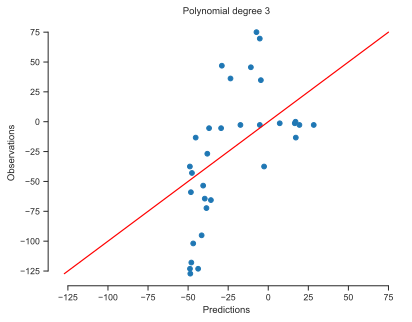

In [9]:
Phi_poly_test = get_polynomial_design_matrix(
    x_test[:, None],
    degree
)
y_test_predict = Phi_poly_test @ w_poly

fig, ax = plt.subplots()
ax.set_title(f'Polynomial degree {degree}')
ax.plot(y_test_predict, y_test, 'o')
yys = np.linspace(y_test.min(), y_test.max(), 100)
ax.plot(yys, yys, 'r-');
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations')
sns.despine(trim=True);

Notice that I have included a red line that goes through the origin at a 45-degree angle with the x-axis in this plot.
This red line marks the perfect fit, i.e., a perfect agreement between the predictions and the observations.
In other words, the closer the blue dots get to the red line, the better the model.

## The mean squared error

The predictions-vs-observations plot is excellent.
But sometimes, you want to characterize your model using a number.
The mean squared error (MSE) is a scalar measure of the goodness of fit.
The MSE is the *mean* of the *sum* of the *square* of the *prediction error* over your test data.
If we assume that you have $n_t$ test data points with inputs $x_{t,i}$ and outputs $y_{t,i}$, the MSE of your model is:

$$
\text{MSE} = \frac{\sum_{i=1}^{n_t}\left[y_{t,i} - \mathbf{w}^T\boldsymbol{\phi}(x_{t,i})\right]^2}{n_t}.
$$

In the polynomial model we fitted above, it is:

In [10]:
MSE_poly = np.mean((y_test_predict - y_test) ** 2)
print(f'MSE_poly = {MSE_poly:1.2f}')

MSE_poly = 2047.76


Now, it is evident that a smaller MSE means a better model.
However, it is hard to understand the absolute meaning of the MSE.
So, sometimes, we look at the relative MSE or (RMSE).
RMSE is the MSE of your model divided by the MSE of the simplest possible model you could make.
Okay. What is the simplest viable model you could make?
It is a constant model.
A model that predicts the same value for the output $y$ no matter what the input $x$ is.
So, mathematically, the model is:

$$
y_{\text{simplest}} = c,
$$

for some constant $c$. What is the best such constant?
You can fit it by minimizing the sum of square errors for this simple model.
If you do it, you will get, very intuitively, that the constant should be the empirical average of your training data, i.e.,

$$
y_{\text{simplest}} = \hat{\mu} = \frac{1}{n}\sum_{i=1}^ny_i.
$$

So, the MSE of this simple model is just:

$$
\text{MSE}_{\text{simplest}} = \frac{\sum_{i=1}^{n_t}\left(y_{t,i} - \hat{\mu}\right)^2}{n_t}.
$$

And we define RMSE to be:

$$
\text{RMSE} = \frac{\text{MSE}}{\text{MSE}_{\text{simplest}}} = \frac{\sum_{i=1}^{n_t}\left[y_{t,i} - \mathbf{w}^T\boldsymbol{\phi}(x_{t,i})\right]^2}{\sum_{i=1}^{n_t}\left(y_{t,i} - \hat{\mu}\right)^2}.
$$

Now, RMSE has an intuitive meaning.
If it is smaller than one, then this means that your model is doing something better than the simplest possible model.
And the smaller it is, the better you do compared to the simplest model.
If the RMSE exceeds one, your model could be better.

```{note}
Sometimes, the acronym RMSE is used for the root mean square error, which is just the square root of the MSE.
Make sure you know which one you are using.
```

Let's find the RMSE for our case:

In [11]:
mu = y_train.mean()
MSE_simplest = np.mean((y_test - mu) ** 2)
print(f'MSE_simplest = {MSE_simplest:1.2f}')
RMSE_poly = MSE_poly / MSE_simplest
print(f'RMSE_poly = {RMSE_poly:1.2f}')

MSE_simplest = 3150.87
RMSE_poly = 0.65


## Coefficient of determination $R^2$

The coefficient of determination is defined by:

$$
R^2 = 1 - \text{RMSE} = 1 - \frac{\sum_{i=1}^{n_t}\left[y_{t,i} - \mathbf{w}^T\boldsymbol{\phi}(x_{t,i})\right]^2}{\sum_{i=1}^{n_t}\left(y_{t,i} - \hat{\mu}\right)^2}.
$$

This measure tells you how much of the percentage of the variance of the test data is explained by your model.
So, you want to get as close to one as possible here.

Let's see what we get in our case:

In [12]:
R2_poly = 1 - RMSE_poly
print('R2 = {0:1.2f}'.format(R2_poly))

R2 = 0.35


So, in this example, our model explains about 23% of the variance of the test data.
What is the rest?
Well, the rest is explained by the measurement noise variance.

### Questions

+ Experiment with polynomials of degrees 4, 5, 10, and 20.
+ When are we underfitting?
+ When are we overfitting?
+ Which degree (if any) gives you the best fit?
+ Use the code blocks below to repeat this analysis for the Fourier and radial basis functions. Which choice of the three basis functions is better? Why?

## Example: Repeat the fitting using Fourier features

Below, I train a model on the same dataset using Fourier features instead of polynomials.
Let's see what we get.

In [13]:
fourier_terms = 10
fourier_L = 60.0
Phi_fourier_train = get_fourier_design_matrix(
    x_train[:, None],
    fourier_L,
    fourier_terms
)
w_fourier, _, _, _ = np.linalg.lstsq(
    Phi_fourier_train,
    y_train,
    rcond=None
)

The predictions plot:

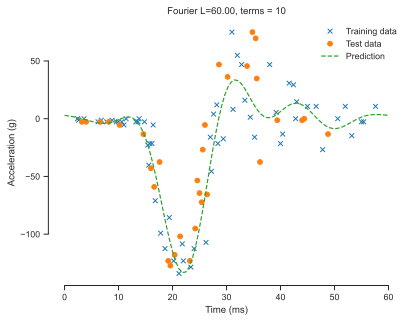

In [14]:
xx = np.linspace(0, 60, 100)
Phi_fourier_xx = get_fourier_design_matrix(
    xx[:, None],
    fourier_L,
    fourier_terms
)
yy_predict = Phi_fourier_xx @ w_fourier

fig, ax = plt.subplots()
ax.set_title(f'Fourier L={fourier_L:1.2f}, terms = {fourier_terms}')
ax.plot(x_train, y_train, 'x', label='Training data')
ax.plot(x_test, y_test, 'o', label='Test data')
ax.plot(xx, yy_predict, '--', label='Prediction')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Acceleration (g)')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

And here is the predictions-vs-observations plot:

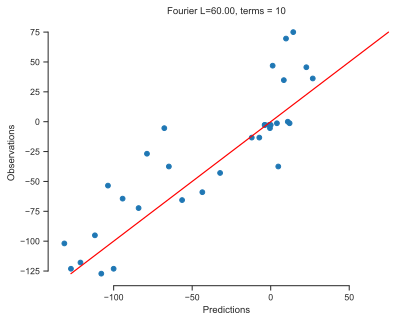

In [15]:
Phi_fourier_test = get_fourier_design_matrix(
    x_test[:, None],
    fourier_L,
    fourier_terms
)
y_test_predict = Phi_fourier_test @ w_fourier

fig, ax = plt.subplots()
ax.set_title(
    f'Fourier L={fourier_L:1.2f}, terms = {fourier_terms}'
)
ax.plot(y_test_predict, y_test, 'o')
yys = np.linspace(y_test.min(), y_test.max(), 100)
ax.plot(yys, yys, 'r-');
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations')
sns.despine(trim=True);

And the error metrics we developed:

In [16]:
MSE_fourier = np.mean((y_test_predict - y_test) ** 2)
RMSE_fourier = MSE_fourier / MSE_simplest
R2_fourier = 1 - RMSE_fourier

print(f'MSE_fourier = {MSE_fourier:1.2f}')
print(f'RMSE_fourier = {RMSE_fourier:1.2f}')
print(f'R2 = {R2_fourier:1.2f}')

MSE_fourier = 820.57
RMSE_fourier = 0.26
R2 = 0.74


You see that this does much, much better than the polynomial model by all measures.
In particular, R2 tells us that our model explains 81% of the variance of the test data.

### Questions
+ Modify the code blocks above to use radial basis functions instead of the Fourier basis.